<a href="https://colab.research.google.com/github/DariusTheGeek/Football-Predictions-Mchezopesa-Ltd/blob/master/Soccer_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research Question.
Predict the result of a game between team 1 and team 2, based on who's home and who's away, and on whether or not the game is friendly - using five features i.e Home team, Away team, Tournament type, Rank of home team and Rank of away team


---

### Approach 1: Using Polynomial regression.
Create a model that can predict how many goals the home team scores 


### Approach 2: Using Logistic Regression.
Create a model that can predict whether the home team will win, draw or lose

## Metric for Success
For Polynomial regression, the Root Mean Squared Error will be used to measure the performace of the model.
The predictive power of the logistic regression model will be measured using the accuracy score and the f1_score

In [0]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix
import requests
from io import StringIO
import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [0]:
# Creating a function to read a csv file shared via google drive
def read_google_csv(url):
  url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
  csv_raw = requests.get(url).text
  csv = StringIO(csv_raw)
  return csv

In [3]:
# Loading the data the fifa ranking dataset into a pandas dataframe
# Previewing the first five rows of the dataset
#
fifa_ranking_dataset_url = 'https://drive.google.com/file/d/1sMiLf1tsXVb4jbgKaHgSjZ6Js0ev7dIf/view?usp=sharing'

ranking = pd.read_csv(read_google_csv(fifa_ranking_dataset_url))
ranking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [4]:
# Previewing some information of the fifa ranking dataset
#
ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57793 entries, 0 to 57792
Data columns (total 16 columns):
rank                       57793 non-null int64
country_full               57793 non-null object
country_abrv               57793 non-null object
total_points               57793 non-null float64
previous_points            57793 non-null int64
rank_change                57793 non-null int64
cur_year_avg               57793 non-null float64
cur_year_avg_weighted      57793 non-null float64
last_year_avg              57793 non-null float64
last_year_avg_weighted     57793 non-null float64
two_year_ago_avg           57793 non-null float64
two_year_ago_weighted      57793 non-null float64
three_year_ago_avg         57793 non-null float64
three_year_ago_weighted    57793 non-null float64
confederation              57793 non-null object
rank_date                  57793 non-null object
dtypes: float64(9), int64(3), object(4)
memory usage: 7.1+ MB


In [5]:
# Previewing some statistical summaries of the fifa ranking dataset
#
ranking.describe()

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted
count,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000,57793.000000
mean,101.628086,122.068637,332.302926,-0.009897,61.798602,61.798602,61.004602,30.502377,59.777462,17.933277,59.173916,11.834811
std,58.618424,260.426863,302.872948,5.804309,138.014883,138.014883,137.688204,68.844143,136.296079,40.888849,135.533343,27.106675
min,1.000000,0.000000,0.000000,-72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,0.000000,56.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,101.000000,0.000000,272.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,152.000000,92.790000,525.000000,1.000000,32.250000,32.250000,26.660000,13.330000,21.500000,6.450000,21.250000,4.250000
max,209.000000,1775.030000,1920.000000,92.000000,1158.660000,1158.660000,1169.570000,584.790000,1159.710000,347.910000,1200.770000,240.150000


In [6]:
# Checking for missing values of the fifa ranking dataset
#
ranking.isnull().sum()

rank                       0
country_full               0
country_abrv               0
total_points               0
previous_points            0
rank_change                0
cur_year_avg               0
cur_year_avg_weighted      0
last_year_avg              0
last_year_avg_weighted     0
two_year_ago_avg           0
two_year_ago_weighted      0
three_year_ago_avg         0
three_year_ago_weighted    0
confederation              0
rank_date                  0
dtype: int64

In [7]:
# Checking for duplicates
#
ranking.duplicated().any()

True

In [0]:
# Removing duplicates

ranking.drop_duplicates(keep='first', inplace = True)

In [9]:
# Checking whether the duplicates have been removed
#
ranking.duplicated().any()

False

In [10]:
# Loading the results dataset into a pandas dataframe
# Previewing the first five rows of the dataset
#

results_dataset_url = 'https://drive.google.com/file/d/1ta3oG4bTsqM1GVgTuq0ElRaLJHb1oZRl/view?usp=sharing'

results = pd.read_csv(read_google_csv(results_dataset_url))
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [11]:
# Previewing some information of the results dataset
#
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40839 entries, 0 to 40838
Data columns (total 9 columns):
date          40839 non-null object
home_team     40839 non-null object
away_team     40839 non-null object
home_score    40839 non-null int64
away_score    40839 non-null int64
tournament    40839 non-null object
city          40839 non-null object
country       40839 non-null object
neutral       40839 non-null bool
dtypes: bool(1), int64(2), object(6)
memory usage: 2.5+ MB


In [12]:
# Previewing some statistical summaries of the results dataset
#
results.describe()

,home_score,away_score
count,40839.000000,40839.000000
mean,1.745709,1.188105
std,1.749145,1.405120
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [13]:
# Checking for missing values of the results dataset
#
results.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [14]:
# Checking for duplicates
#
results.duplicated().any()

False

In [0]:
# Renaming the rank_date column
#
ranking.rank_date = ranking.rename({'rank_date': 'date'}, axis = 1, inplace = True)

In [0]:
# Making the date columns uniform
#
results.date = results.date.apply(lambda x: x.replace('/', '-'))
ranking.date = ranking.date.apply(lambda x: x.replace('/', '-'))

In [0]:
# Changing the date columns to datetime objects
#
ranking.date = pd.to_datetime(ranking.date)
results.date = pd.to_datetime(results.date)

# Creating a year and month column from the datetime object
#
ranking['year'] = ranking.date.dt.year
results['year'] = results.date.dt.year

ranking['month'] = ranking.date.dt.month
results['month'] = ranking.date.dt.month

In [18]:
# Checking the unique years in the ranking dataset
#
ranking.year.unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [19]:
# Checking the unique years in the results dataset
#
results.year.unique()

array([1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019])

In [0]:
# Merging the results dataframe to the ranking dataframe
# The dataframes have been joined on both year and month
#
combined = pd.merge(results, ranking, how = 'left', left_on = ['year', 'month'], right_on = ['year', 'month'])

In [21]:
# Previewing the first five columns of the combined dataset
#
combined.head()

,date_x,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,date_y
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [22]:
# Selecting the ranking details of the home team only
#
home_combined = combined[combined.home_team == combined.country_full]
#previewing the first five rows of the home_combined dataframe
#
home_combined.head()

,date_x,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,date_y
18192,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False,1994,4,99.0,Barbados,BRB,0.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,1994-04-19
18291,1994-01-02,Ghana,Egypt,2,1,Friendly,Accra,Ghana,False,1994,4,29.0,Ghana,GHA,0.0,41.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19
18479,1994-01-05,Mali,Burkina Faso,1,1,Friendly,Bamako,Mali,False,1994,4,48.0,Mali,MLI,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19
18747,1994-01-09,Mauritania,Mali,1,3,Friendly,Nouakchott,Mauritania,False,1994,4,147.0,Mauritania,MTN,0.0,3.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19
18838,1994-01-11,Thailand,Nigeria,1,1,Friendly,Bangkok,Thailand,False,1994,4,69.0,Thailand,THA,0.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AFC,1994-04-19


In [23]:
# Getting the columns to be renamed
#
home_combined.columns[11:-2]

Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted'],
      dtype='object')

In [24]:
# Renaming the selected home_combined columns using a for loop
# 
for x, y in zip(home_combined.columns[11:-2], home_combined.columns[11:-2]):
  home_combined.rename(columns = {x: y + '_home'}, inplace = True)
  
# Previewing the renamed columns
home_combined.columns[11:-2]

Index(['rank_home', 'country_full_home', 'country_abrv_home',
       'total_points_home', 'previous_points_home', 'rank_change_home',
       'cur_year_avg_home', 'cur_year_avg_weighted_home', 'last_year_avg_home',
       'last_year_avg_weighted_home', 'two_year_ago_avg_home',
       'two_year_ago_weighted_home', 'three_year_ago_avg_home',
       'three_year_ago_weighted_home'],
      dtype='object')

In [25]:
# Selecting the ranking details of the away team only
#
away_combined = combined[combined.away_team == combined.country_full]
#previewing the first five rows of the away_combined dataframe
#
away_combined.head()

,date_x,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,date_y
18224,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False,1994,4,131.0,Grenada,GRN,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,1994-04-19
18286,1994-01-02,Ghana,Egypt,2,1,Friendly,Accra,Ghana,False,1994,4,24.0,Egypt,EGY,0.0,44.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19
18532,1994-01-05,Mali,Burkina Faso,1,1,Friendly,Bamako,Mali,False,1994,4,101.0,Burkina Faso,BFA,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19
18648,1994-01-09,Mauritania,Mali,1,3,Friendly,Nouakchott,Mauritania,False,1994,4,48.0,Mali,MLI,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19
18774,1994-01-11,Thailand,Nigeria,1,1,Friendly,Bangkok,Thailand,False,1994,4,5.0,Nigeria,NGA,0.0,49.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19


In [26]:
# Getting the columns to be renamed in the away_combined dataframe
#
away_combined.columns[11:-2]

Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted'],
      dtype='object')

In [27]:
# Renaming the selected away_combined columns using a for loop
# 
for x, y in zip(away_combined.columns[11:-2], away_combined.columns[11:-2]):
  away_combined.rename(columns = {x: y + '_away'}, inplace = True)
  
# Previewing the renamed columns
away_combined.columns[11:-2]

Index(['rank_away', 'country_full_away', 'country_abrv_away',
       'total_points_away', 'previous_points_away', 'rank_change_away',
       'cur_year_avg_away', 'cur_year_avg_weighted_away', 'last_year_avg_away',
       'last_year_avg_weighted_away', 'two_year_ago_avg_away',
       'two_year_ago_weighted_away', 'three_year_ago_avg_away',
       'three_year_ago_weighted_away'],
      dtype='object')

In [28]:
# Selecting only the relevant columns in the away_combined dataframe
# Creating a list of relevant columns
#
relevant_cols = list(away_combined.columns[9:-2])
relevant_cols.extend(['home_team', 'away_team'])

away_combined = away_combined[relevant_cols]

# Previewing the first two columns of the away_combined dataset
#
away_combined.head()

,year,month,rank_away,country_full_away,country_abrv_away,total_points_away,previous_points_away,rank_change_away,cur_year_avg_away,cur_year_avg_weighted_away,last_year_avg_away,last_year_avg_weighted_away,two_year_ago_avg_away,two_year_ago_weighted_away,three_year_ago_avg_away,three_year_ago_weighted_away,home_team,away_team
18224,1994,4,131.0,Grenada,GRN,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Barbados,Grenada
18286,1994,4,24.0,Egypt,EGY,0.0,44.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ghana,Egypt
18532,1994,4,101.0,Burkina Faso,BFA,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mali,Burkina Faso
18648,1994,4,48.0,Mali,MLI,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mauritania,Mali
18774,1994,4,5.0,Nigeria,NGA,0.0,49.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Thailand,Nigeria


In [29]:
# Merging the home_combined dataframe to the away_combined dataframe
# The two dataframes have been merged on year, month, home_team and away_team columns
#
final_df = pd.merge(home_combined, away_combined, how = 'left' , left_on =['year', 'month', 'home_team', 'away_team'],\
                    right_on = ['year', 'month', 'home_team', 'away_team'])
# Previewing the first five rows of the merged dataframe
final_df.head()

,date_x,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank_home,country_full_home,country_abrv_home,total_points_home,previous_points_home,rank_change_home,cur_year_avg_home,cur_year_avg_weighted_home,last_year_avg_home,last_year_avg_weighted_home,two_year_ago_avg_home,two_year_ago_weighted_home,three_year_ago_avg_home,three_year_ago_weighted_home,confederation,date_y,rank_away,country_full_away,country_abrv_away,total_points_away,previous_points_away,rank_change_away,cur_year_avg_away,cur_year_avg_weighted_away,last_year_avg_away,last_year_avg_weighted_away,two_year_ago_avg_away,two_year_ago_weighted_away,three_year_ago_avg_away,three_year_ago_weighted_away
0,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False,1994,4,99.0,Barbados,BRB,0.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,1994-04-19,131.0,Grenada,GRN,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False,1994,4,99.0,Barbados,BRB,0.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,1994-04-19,131.0,Grenada,GRN,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1994-01-02,Ghana,Egypt,2,1,Friendly,Accra,Ghana,False,1994,4,29.0,Ghana,GHA,0.0,41.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19,24.0,Egypt,EGY,0.0,44.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1994-01-05,Mali,Burkina Faso,1,1,Friendly,Bamako,Mali,False,1994,4,48.0,Mali,MLI,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19,101.0,Burkina Faso,BFA,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1994-01-09,Mauritania,Mali,1,3,Friendly,Nouakchott,Mauritania,False,1994,4,147.0,Mauritania,MTN,0.0,3.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1994-04-19,48.0,Mali,MLI,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Removing irrelevant columns from the final dataframe
# Creating a list of columns to be dropped
#
drop_cols = ['country_full_home', 'country_abrv_home', 'date_y', 'country_full_away',	'country_abrv_away']
final_df.drop(drop_cols, axis = 1, inplace = True)

In [31]:
# Checking for missing values
# This is because a left join was used
#
final_df.isnull().sum()

date_x                             0
home_team                          0
away_team                          0
home_score                         0
away_score                         0
tournament                         0
city                               0
country                            0
neutral                            0
year                               0
month                              0
rank_home                          0
total_points_home                  0
previous_points_home               0
rank_change_home                   0
cur_year_avg_home                  0
cur_year_avg_weighted_home         0
last_year_avg_home                 0
last_year_avg_weighted_home        0
two_year_ago_avg_home              0
two_year_ago_weighted_home         0
three_year_ago_avg_home            0
three_year_ago_weighted_home       0
confederation                      0
rank_away                       1811
total_points_away               1811
previous_points_away            1811
r

In [0]:
# Dropping missing values
#
final_df.dropna(inplace=True)

In [0]:
# Creating a copy of the final_df for later usage
#
df = final_df.copy()

In [34]:
# Previewing the first five rows of the engineered dataframe
#
df.head()

,date_x,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank_home,total_points_home,previous_points_home,rank_change_home,cur_year_avg_home,cur_year_avg_weighted_home,last_year_avg_home,last_year_avg_weighted_home,two_year_ago_avg_home,two_year_ago_weighted_home,three_year_ago_avg_home,three_year_ago_weighted_home,confederation,rank_away,total_points_away,previous_points_away,rank_change_away,cur_year_avg_away,cur_year_avg_weighted_away,last_year_avg_away,last_year_avg_weighted_away,two_year_ago_avg_away,two_year_ago_weighted_away,three_year_ago_avg_away,three_year_ago_weighted_away
0,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False,1994,4,99.0,0.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,131.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False,1994,4,99.0,0.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,131.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1994-01-02,Ghana,Egypt,2,1,Friendly,Accra,Ghana,False,1994,4,29.0,0.0,41.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,24.0,0.0,44.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1994-01-05,Mali,Burkina Faso,1,1,Friendly,Bamako,Mali,False,1994,4,48.0,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,101.0,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1994-01-09,Mauritania,Mali,1,3,Friendly,Nouakchott,Mauritania,False,1994,4,147.0,0.0,3.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,48.0,0.0,31.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Checking the datatypes of the df dataframe
#
df.dtypes

date_x                          datetime64[ns]
home_team                               object
away_team                               object
home_score                               int64
away_score                               int64
tournament                              object
city                                    object
country                                 object
neutral                                   bool
year                                     int64
month                                    int64
rank_home                              float64
total_points_home                      float64
previous_points_home                   float64
rank_change_home                       float64
cur_year_avg_home                      float64
cur_year_avg_weighted_home             float64
last_year_avg_home                     float64
last_year_avg_weighted_home            float64
two_year_ago_avg_home                  float64
two_year_ago_weighted_home             float64
three_year_ag

In [0]:
# Changing the df dataframe datatypes to their appriopriate datatype
# creating a list of categorical columns
#
cat_cols = ['home_team', 'away_team', 'tournament', 'city', 'country', 'neutral', 'year', 'month']

# Using a for loop to change the datatypes to categorical
#
for col in cat_cols:
  df[col] = df[col].astype('category')

In [0]:
# Creating a new column showing the final result
# The column has been created by subtracting the away score from the home score
# zero goals means a draw
# Positive goals means the home team won
# Negative goals means the away team won, which means that the home team lost.
#
df['score'] = df.home_score - df.away_score

In [38]:
# Previewing the first five rows of the score column
#
df.score.head()

0    0
1    0
2    1
3    0
4   -2
Name: score, dtype: int64

In [39]:
# Creating a function to be used to create a win, draw or lose column
#
def result(goals):
  if goals > 0:
    return 'Win'
  elif goals < 0:
    return 'Lose'
  else:
    return 'Draw'
# Applying the result function to the dataframe
#
df['result'] = df.score.apply(lambda x: result(x))

# Dropping the score column, as it has served its purpose
#
df.drop('score', axis = 1, inplace = True)

# Creating a column of total goals scored
#
df['total_goals'] = df.home_score + df.away_score

# Previewing the last five rows of the dataframe together with the result column
#
df.tail()

,date_x,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,rank_home,total_points_home,previous_points_home,rank_change_home,cur_year_avg_home,cur_year_avg_weighted_home,last_year_avg_home,last_year_avg_weighted_home,two_year_ago_avg_home,two_year_ago_weighted_home,three_year_ago_avg_home,three_year_ago_weighted_home,confederation,rank_away,total_points_away,previous_points_away,rank_change_away,cur_year_avg_away,cur_year_avg_weighted_away,last_year_avg_away,last_year_avg_weighted_away,two_year_ago_avg_away,two_year_ago_weighted_away,three_year_ago_avg_away,three_year_ago_weighted_away,result,total_goals
20537,2018-10-16,Japan,Uruguay,4,3,Friendly,Saitama,Japan,False,2018,6,61.0,520.75,528.0,-1.0,164.51,164.51,413.01,206.50,273.24,81.97,338.88,67.78,AFC,14.0,1018.41,976.0,3.0,486.28,486.28,487.69,243.84,561.47,168.44,599.26,119.85,Win,7
20538,2018-10-16,Laos,Mongolia,1,4,Friendly,Vientiane,Laos,False,2018,6,178.0,81.58,80.0,1.0,21.25,21.25,65.52,32.76,63.57,19.07,42.50,8.50,AFC,186.0,51.00,51.0,2.0,8.50,8.50,34.00,17.00,0.00,0.00,127.50,25.50,Lose,5
20540,2018-10-16,Mexico,Chile,0,1,Friendly,Queretaro,Mexico,False,2018,6,15.0,989.44,1008.0,0.0,470.55,470.55,506.78,253.39,579.97,173.99,457.54,91.51,CONCACAF,9.0,1134.66,1146.0,0.0,403.99,403.99,831.33,415.67,724.98,217.49,487.56,97.51,Lose,1
20541,2018-10-16,Oman,Ecuador,0,0,Friendly,Doha,Qatar,True,2018,6,84.0,391.06,383.0,3.0,259.44,259.44,114.64,57.32,192.68,57.80,82.45,16.49,AFC,60.0,523.85,506.0,3.0,67.14,67.14,387.50,193.75,630.02,189.01,369.77,73.95,Draw,0
20542,2018-10-16,Sweden,Slovakia,1,1,Friendly,Stockholm,Sweden,False,2018,6,24.0,879.90,889.0,-1.0,478.44,478.44,431.99,215.99,370.10,111.03,372.19,74.44,UEFA,28.0,804.36,786.0,1.0,332.12,332.12,454.01,227.01,325.92,97.77,737.30,147.46,Draw,2


## Exploratory data analysis

### Checking for outliers

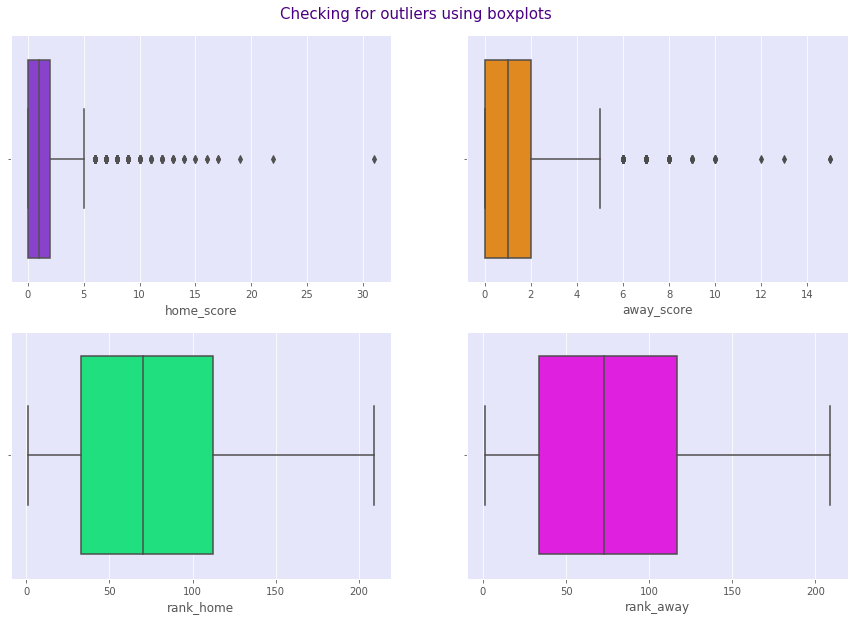

In [40]:
# Creating a list of columns to check for outliers
# Creating a list of colors
#
col_list = ['home_score', 'away_score', 'rank_home', 'rank_away']
colors = ['blueviolet', 'darkorange', 'springgreen', 'fuchsia']

# Plotting boxplots of the col_list columns to check for outliers
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Checking for outliers using boxplots', fontsize = 15, y = 0.92, color = 'indigo')
for ax, data, column, color in zip(axes.flatten(), df, col_list, colors):
  sns.boxplot(df[column], ax = ax, color = color)
  ax.set_facecolor('lavender') # Setting the background color to lavender

*From the above boxplots, it can be seen that both the home score and away score columns have outliers. The outliers are important for modelling, so they will not be dropped*

#### Scatterplots

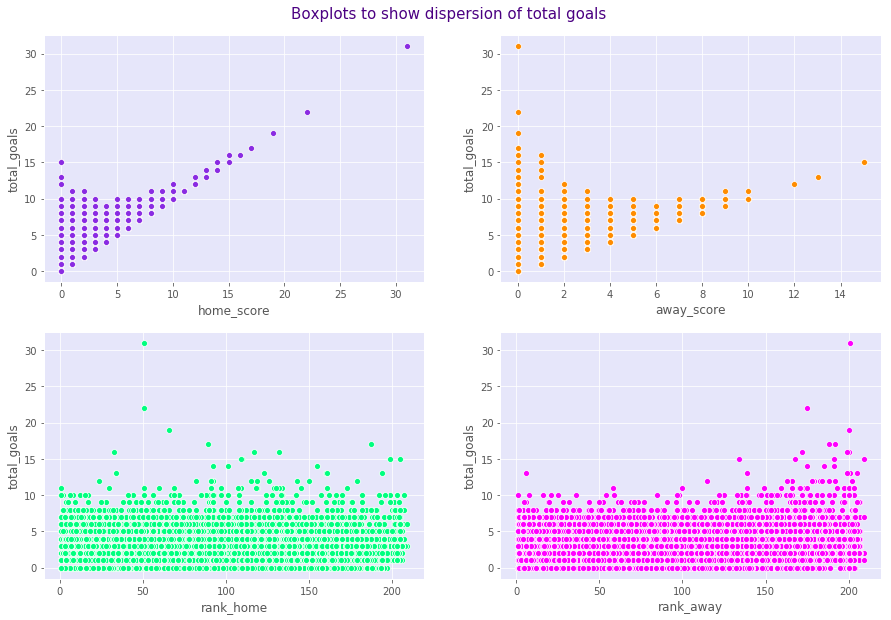

In [41]:
# Plotting scatter plots to show dispersion of total goals
# Setting the figure size to 15 by 10
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Boxplots to show dispersion of total goals', fontsize = 15, y = 0.92, color = 'indigo')
for ax, data, column, color in zip(axes.flatten(), df, col_list, colors):
  sns.scatterplot(df[column], df.total_goals, ax = ax, color = color)
  ax.set_facecolor('lavender') # Setting the background color to lavender

### Distribution of home and away goals

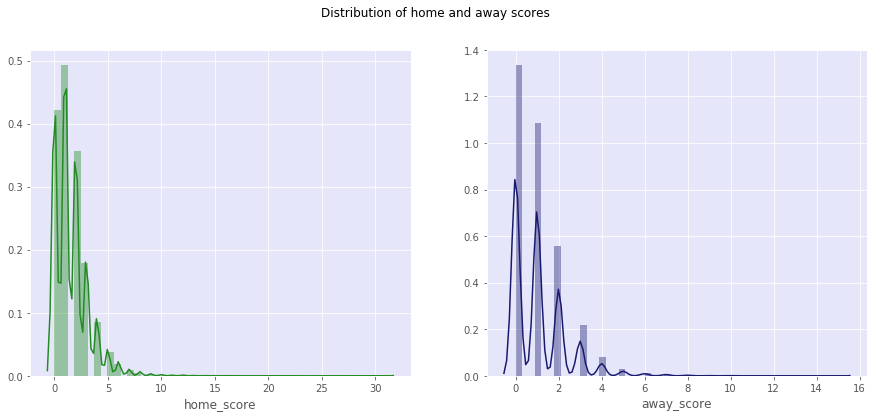

In [42]:
# Using displots to plot distribution of home and away scores
#
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
plt.suptitle('Distribution of home and away scores')
for ax, data, column, color in zip(axes.flatten(), df, ['home_score', 'away_score'], ['forestgreen', 'midnightblue']):
  sns.distplot(df[column], ax = ax, hist = True, color = color)
  ax.set_facecolor('lavender')

*From the above histograms, it can be observed that the plots are skewed to the right, which means that the mean is less than both the median and mode of goals scored*

### Teams with highest number of goals in all of the tournaments

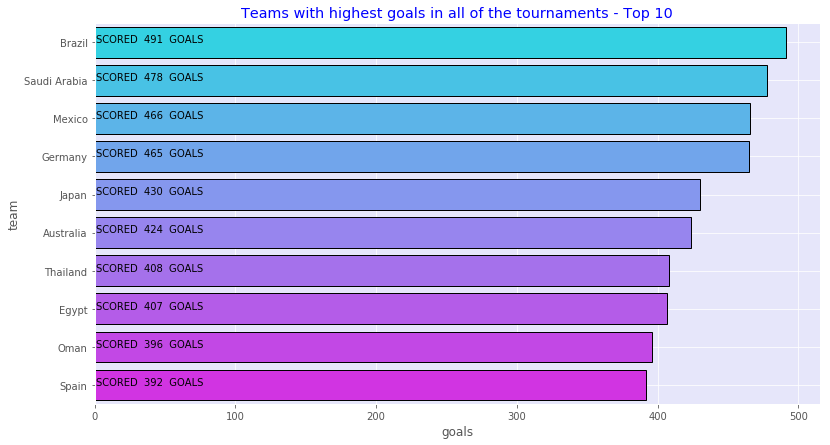

In [43]:
# Creating a dataframe of home teams with their total goals scored
#
total_goals_home = df.groupby('home_team')['home_score'].sum().reset_index()
total_goals_home.columns = ['team', 'goals'] # Giving the dataframe column names

# Creating a dataframe of away teams with their total goals scored
#
total_goals_away = df.groupby('away_team')['away_score'].sum().reset_index()
total_goals_away.columns = ['team', 'goals'] # Giving the dataframe column names

# Concating the two dataframes together and then grouping dataframes by team to find total goals scored
#
total_goals = pd.concat([total_goals_home, total_goals_away])
total_golas = total_goals.sort_values(by = 'goals', ascending = False, inplace = True) # sorting the teams by goals scored
total_goals.goals = total_goals.goals.astype(int) # Changing the datatype of the goals column to integer

plt.figure(figsize=(13,7))  # Creating a figure of length 13 and height 7
ax= sns.barplot("goals","team",data=total_goals[:10],palette="cool",linewidth=1, edgecolor="k"*20)

ax.set_facecolor('lavender') # Setting the background color to lavender

for i,j in enumerate("SCORED  " + total_goals["goals"][:10].astype(str) + "  GOALS"): # Annotating the barplot
    ax.text(.7,i,j,fontsize = 10, color="k")

plt.title("Teams with highest goals in all of the tournaments - Top 10",color='b')
plt.grid(True)
plt.show()

*From the above barchart it can be deduced that, Brazil scored the highest number of goals followed closely by Saudi Arabia.
The total goals in the above chart are representative of all tournaments that the team participated*

### Highest total goals scored during a match

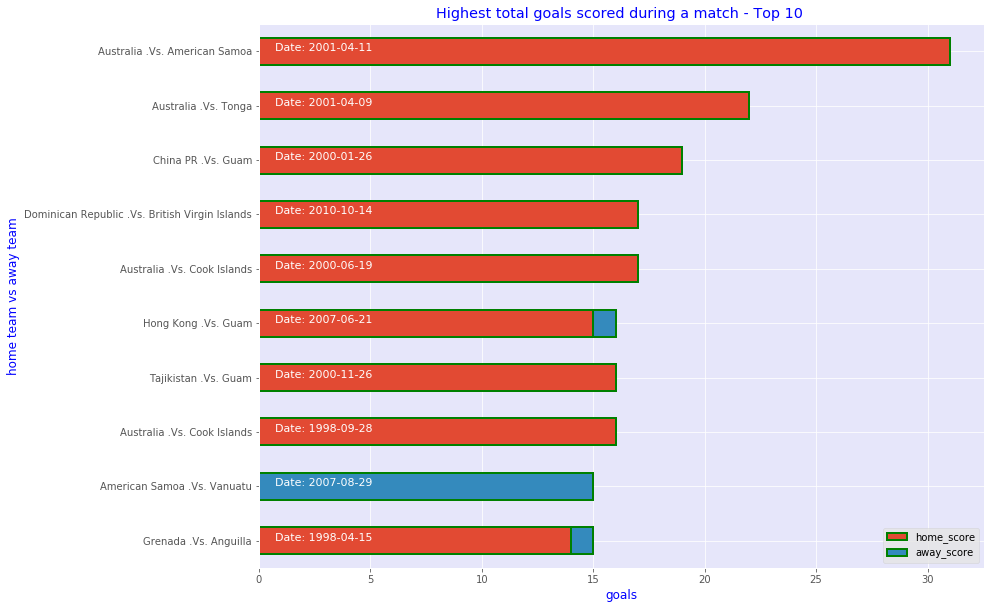

In [44]:
# Creating a dataframe of total goals scored and then sorting the dataframe by total goals
#
highest_goals = df.sort_values(by = 'total_goals', ascending = False)[:10][['date_x', 'home_team', 'away_team', 'home_score', 'away_score', 'total_goals']]

# Creating the y axis label
#
highest_goals['match'] = highest_goals[['home_team', 'away_team']].apply(lambda x: ' .Vs. '.join(x), axis = 1)
highest_goals.index = highest_goals.match

highest_goals = highest_goals.sort_values(by = 'total_goals', ascending = True) # Sorting the dataframe by total goals

# Plotting a horizontal barchart
#
ax = highest_goals[['home_score', 'away_score']].plot(kind="barh",stacked=True,figsize=(13,10),linewidth=2,edgecolor="g"*15)

# Setting the background color to papayawhip
#
ax.set_facecolor('lavender')
highest_goals.date_x = highest_goals.date_x.astype(str)

plt.ylabel("home team vs away team",color="b") # Naming the y axis
plt.xlabel("goals",color="b") # Naming the x axis
plt.title("Highest total goals scored during a match - Top 10 ",color='b') # Giving the chart a title

# Using a for loop to annotate the chart
#
for i,j in enumerate('Date: ' + highest_goals.date_x):
    ax.text(.7,i,j,color="w",fontsize=11)
  
# Displaying the chart
plt.show()

*The match with the highest number of gaols scored from the above chart is Australia Vs American Samoa*

### Total goals scored during games by year

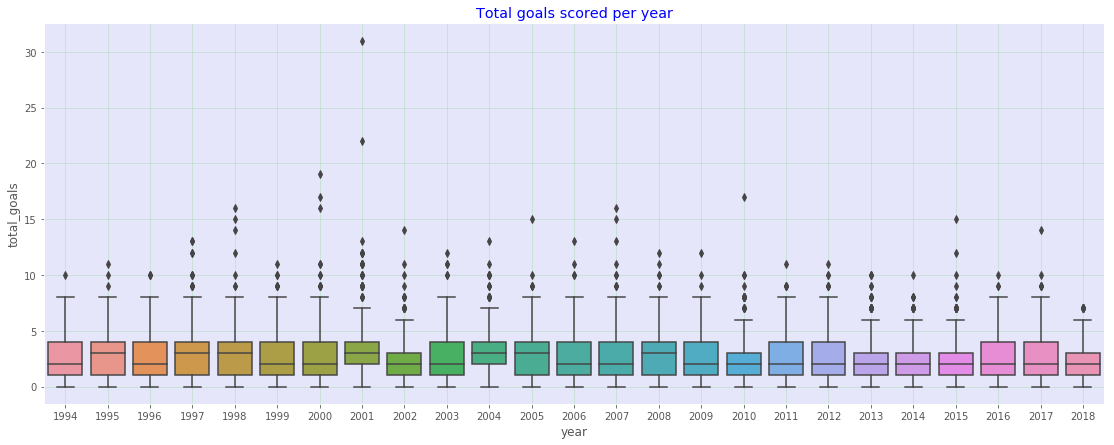

In [45]:
# Plotting boxplots of year against total goals scored
#
plt.figure(figsize=(19,7))  # Setting the figure size to 19 by 7
ax = sns.boxplot(y=df.total_goals,x=df.year) # Plotting the boxplots for each year
ax.set_facecolor('lavender')
plt.grid(True, color = 'limegreen', alpha = 0.2)
plt.title("Total goals scored per year",color='b')
plt.show()

*The year **2001** had the highest number of total goals scored, and the year **2018** had the least number of goals scored*

### Average goals per year

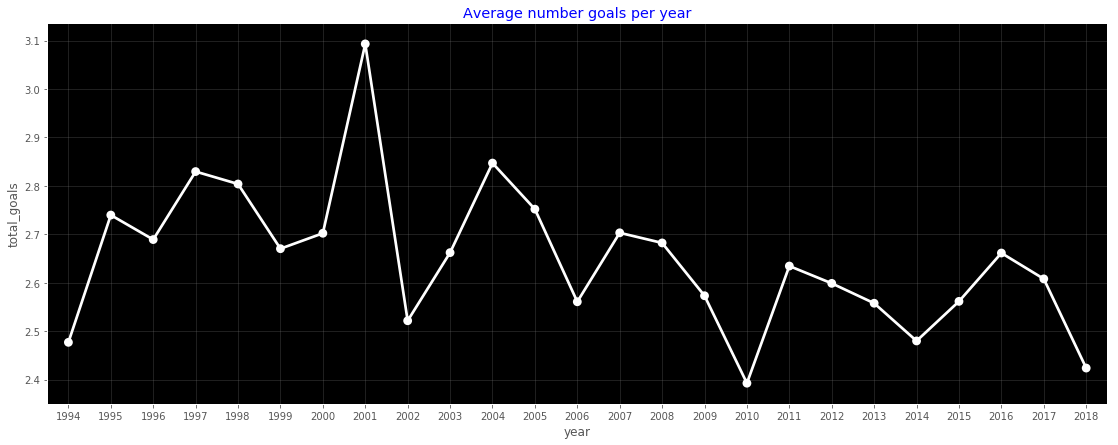

In [46]:
# Creating a dataframe of year and total goals
#
goals = df.groupby('year')['total_goals'].mean().reset_index()
goals.year = goals.year.astype(int) # Changing the datatype of the year column to int

# Setting the figure size of the plot to 19 by 7
plt.figure(figsize=(19,7))
ax = sns.pointplot(goals.year,goals.total_goals,color="w") # Plotting a pointplot to show the trend of average goals scored across the years

ax.set_facecolor("k") # setting the background color to black, for contrast
plt.grid(True,color="grey",alpha=.3) # Setting the color of the grid lines to grey and setting the opacity to 0.3
plt.title("Average number goals per year",color='b') # Giving the chart a title of color blue
plt.show()

*From the above line chart, it can be deduced that; generally the number of goals scored per year has been declining since the year **2001** which had the highest number of goals*

## Approach 1: Using Polynomial regression.
Create a model that can predict how many goals the home team scores

### *Predicting home score*

In [47]:
# Selecting columns relevant to the reasearch question
#
dataset = df[['home_team',	'away_team',	'home_score',	'away_score',	'tournament', 'rank_home', 'rank_away']]
# Previewing the first five rows of the dataset
#
dataset.head()

,home_team,away_team,home_score,away_score,tournament,rank_home,rank_away
0,Barbados,Grenada,0,0,Friendly,99.0,131.0
1,Barbados,Grenada,0,0,Friendly,99.0,131.0
2,Ghana,Egypt,2,1,Friendly,29.0,24.0
3,Mali,Burkina Faso,1,1,Friendly,48.0,101.0
4,Mauritania,Mali,1,3,Friendly,147.0,48.0


#### Checking for multicollinearity
[Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related. We have perfect multicollinearity if, for example as in the equation above, the correlation between two independent variables is equal to 1 or −1

In [48]:
# Displaying the correlations between the variables
#
corrs = dataset.drop('home_score', axis = 1).corr()
corrs

,away_score,rank_home,rank_away
away_score,1.000000,0.213023,-0.184574
rank_home,0.213023,1.000000,0.481889
rank_away,-0.184574,0.481889,1.000000


*The tabe above shows how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself. The correlations have been used to compute the VIF (Variance Inflation Factor) score for each variable.The VIF is created by finding the inverse matrix of the correations matrix.*

In [49]:
# Creating a dataframe of the VIF
#
vif_df = pd.DataFrame(np.linalg.inv(corrs.values), index = corrs.index, columns = corrs.columns)
vif_df

,away_score,rank_home,rank_away
away_score,1.180402,-0.464249,0.441589
rank_home,-0.464249,1.485040,-0.801313
rank_away,0.441589,-0.801313,1.467650


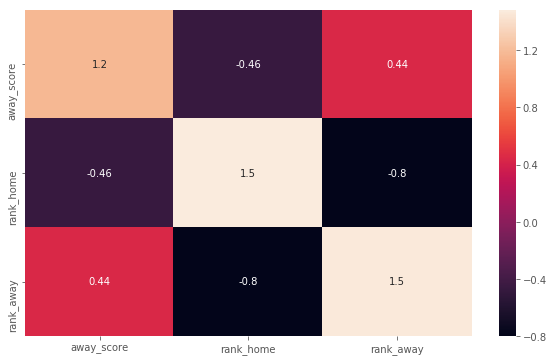

In [50]:
# Creating a heatmap of the vif_df
#
plt.figure(figsize = (10, 6))
sns.heatmap(vif_df, annot = True)
plt.show()

*The VIF score for each variable is found alongside the downwards sloping diagonal. away_score has a score of approximately 1.2, rank_away has a score of approximately 1.5 and rank_away has a score of approximately 1.5.
All of this scores are under 5, therefore there is no multicollinearity*

#### Creating the polynomial model

In [51]:
# Creating X and y variables
#
X = dataset.iloc[:, [0, 1, 3, 4, 5, 6]]
y = dataset.home_score

# Encoding categorical variables
#
X = pd.get_dummies(X, drop_first=True)

# Splitting the dataset into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

# Fitting and transforming the features into a polynomial object
#

# Standardising the X_train and the X_test to the same scale
#
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting the polynomial features to the X_train and X_test
#
poly_features = PolynomialFeatures(degree = 1)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

# Training the model
#
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Making predictions
#
y_pred = regressor.predict(X_test)

# Measuring the accuracy of the model
#
print(np.sqrt(mean_squared_error(y_test, y_pred)))

1.3278064476746914


*The lower the RMSE of a model, the better the performance of the model. Therefore, this model is fairly good in making predictions*

#### Hyperparameter tuning to find the optimalparameters for the model

In [52]:
# Tuning the parameters of the linear regression model to find the optimal 
# Printing the Linear Regression model parameters that can be tuned
#
from sklearn.linear_model import LinearRegression
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
# The parameters that can be tuned are fitting the intercept and normalizing
# Creating a parameters dictionary
#
params = {'normalize': [True, False],
         'fit_intercept': [True, False]}

# Creating a cross validation of 10 folds
#
kfold = KFold(n_splits = 10)

# Using grid search to find the optimal parameters
#
grid_search = GridSearchCV(estimator=regressor, param_grid = params, cv = kfold, scoring = 'neg_mean_squared_error')

# Fitting the grid search 
#
grid_search_results = grid_search.fit(X, y)

# Displaying the best parameters and the the best score
#
print(f'Best score is {grid_search.best_score_} and the best parameters are {grid_search.best_params_}')

Best score is -1.8751910920741375 and the best parameters are {'fit_intercept': True, 'normalize': False}


*The optimal parameters for this model are {'fit_intercept': True, 'normalize': False}*

#### Performing cross validation to check for overfitting or underfitting

In [54]:
# Performing cross validation of ten folds
#
scores = cross_val_score(regressor, X, y, scoring = 'neg_mean_squared_error', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {np.round(scores.mean()*-1, 3)}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {np.round(scores.std(), 3)}')

Mean of cross validation scores is 1.875
Standard deviation of the cross validation scores is 0.241


*From the above mean and standard deviation it can be seen the model is fairly stable, as it varies only by 0.24, from the mean*

#### Checking the appripriateness of the model using a residual plot
A [residual](https://stattrek.com/statistics/dictionary.aspx?definition=residual%20plot) plot is a graph that shows the residuals on the vertical axis and the independent variable on the horizontal axis. If the points in a residual plot are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data; otherwise, a non-linear model is more appropriate.

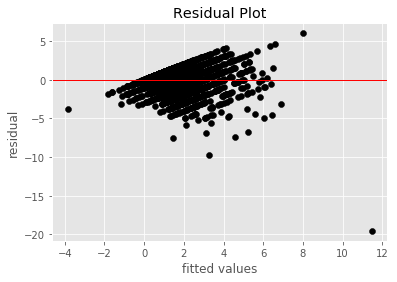

In [55]:
# Creating the residual by substracting the test value from the predicted value
# 

residuals = np.subtract(y_pred, y_test)
# Plotting the residual scatterplot
#
plt.scatter(y_pred, residuals, color='black')
plt.title('Residual Plot')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

*The residuals are centered around a mean that is very close to 0, and there are no glaringly obvious patterns. 
This shows that the model is fairly good*

#### Heteroskedasticity test using the barlett's test
The concept of [heteroscedasticity](https://www.xlstat.com/en/solutions/features/heteroscedasticity-tests) - the opposite being homoscedasticity - is used in statistics, especially in the context of linear regression or for time series analysis, to describe the case where the variance of errors or the model is not the same for all observations, while often one of the basic assumption in modeling is that the variances are homogeneous and that the errors of the model are identically distributed.

The barlett'stest establishes as a null hypothesis that the variance is equal for all our datapoints,and the new hypothesis that the variance is different for at least one pair of datapoints

In [56]:
# Performing the barlett's test
#
test_result, p_value = sp.stats.bartlett(y_pred, residuals)

# Calculating the critical value of the chi squared distribution, to compare it with the test_result
#
degrees_of_freedom = len(y_pred) - 1
probability =  1 - p_value
critical_value = sp.stats.chi2.ppf(probability, degrees_of_freedom)

# If the test_result is greater than the critical value, then the null hypothesis is
# rejected. This means that there are patterns to the variance of the data

# Otherwise, if no patterns are identified, null hypothesis is accepted. This means that 
# the variance is homogeneous across the dataset

if (test_result > critical_value):
  print(f'The test result of {np.round(test_result,2)} is greater than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are unequal, which means that the model should be reassessed')
  print('The variances are heterogenous')
else:
  print(f'The test result of {np.round(test_result,2)} is less than the critical value of {np.round(critical_value, 2)}')
  print('Thefore the variances are equal, which means that the model is okey. No need to reasses')
  print('The variances are homogeneous')

The test result of 521.82 is less than the critical value of inf
Thefore the variances are equal, which means that the model is okey. No need to reasses
The variances are homogeneous


## Approach 2: Using Logistic Regression.
Create a model that can predict whether the home team will win, draw or lose

In [57]:
# Selecting the relevant features for the logistic regression model
#
data = df[['home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'year', 'rank_home', 'rank_away', 'result']]

# Previewing the first five rows of the data
#
data.head()

,home_team,away_team,home_score,away_score,tournament,year,rank_home,rank_away,result
0,Barbados,Grenada,0,0,Friendly,1994,99.0,131.0,Draw
1,Barbados,Grenada,0,0,Friendly,1994,99.0,131.0,Draw
2,Ghana,Egypt,2,1,Friendly,1994,29.0,24.0,Win
3,Mali,Burkina Faso,1,1,Friendly,1994,48.0,101.0,Draw
4,Mauritania,Mali,1,3,Friendly,1994,147.0,48.0,Lose


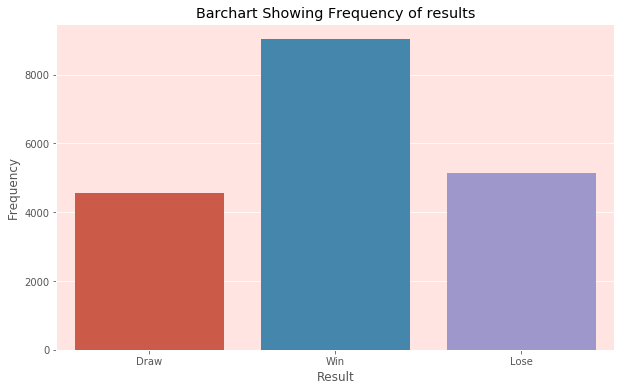

In [58]:
# Checking whether the data is well balanced between all the results; win draw or lose
#
plt.figure(figsize = (10, 6))
ax = sns.countplot(data.result)
ax.set_facecolor('mistyrose')
plt.ylabel('Frequency')
plt.xlabel('Result')
plt.title('Barchart Showing Frequency of results')
plt.show()

*From the above chart, the results are fairly balanced*

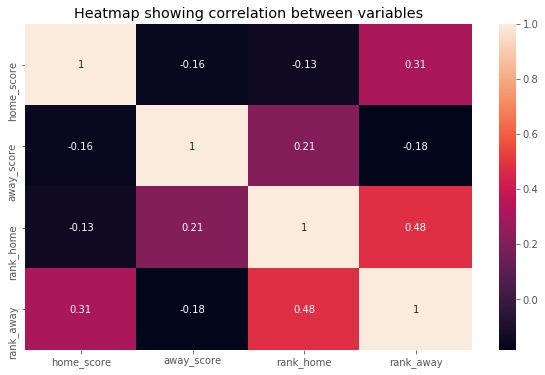

In [59]:
# Checking for independence between features
#
plt.figure(figsize = (10, 6))
sns.heatmap(data.corr(), annot = True) 
plt.title('Heatmap showing correlation between variables')
plt.show()

#### Creating a LogisticRegression model

In [61]:
# Spliting the data into features and the target variable
#
X = data.drop('result', axis = 1)
y = data.result

# Encoding the categorical features
#
X = pd.get_dummies(X, drop_first=True)

# Spliting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

# Instantiating the model and training the model
#
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

# Making predictions
#
y_pred = logistic.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy of the model is {accuracy_score(y_test, y_pred)}')
print(f'The f1 score of the model is {f1_score(y_test, y_pred, average = "macro")}')
confusion_matrix(y_test, y_pred)

The accuracy of the model is 0.9991458466794789
The f1 score of the model is 0.9991092597375367


array([[1119,    0,    4],
       [   0, 1310,    0],
       [   0,    0, 2250]])

*The model above has an accuracy of 100% and an f1_score of 1.
The model is clearly overfitting on the training data; further investigation and assessment is needed*

#### Hyperparameter tuning

In [62]:
# Displaying parameters of the logistic regression model that can be tuned
#
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Creating a dictioanry of parameters to be tuned
#
params = {'C': [1.0, 5.0],
         'penalty': ['l1', 'l2']}

logistic = LogisticRegression()
# Creating a cross validation of 10 folds
#
kfold = KFold(n_splits = 10)

# Using grid search to find the optimal parameters
#
grid_search = GridSearchCV(estimator=logistic, param_grid = params, cv = kfold, scoring = 'accuracy')

# Fitting the grid search 
#
grid_search_results = grid_search.fit(X, y)

# Displaying the best parameters and the the best score
#
print(f'Best score is {grid_search.best_score_} and the best parameters are {grid_search.best_params_}')

*From above, it can observed that the best parameters are {'C': 1.0, 'penalty': 'l1'} which give a score of 1*

## Challenging the solution
Using other models to make pedictions, so as to find the best model

#### Finding the best model

In [0]:
# Importing different classification models
#
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Creating a list of classifier algorithms to compare with
#
models = [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), DecisionTreeClassifier(), XGBClassifier(), SVC(), KNeighborsClassifier(),\
          GaussianNB(), LogisticRegression()]

# Creating lists of the algorithms, to store the accuracy scores of each fold
#
RandomForest, GradientBoosting, AdaBoost, DecisionTree, XGB, SVC, KNeighbors, GaussianNB, LogisticRegression = ([] for x in range(9))

# Creating a list containig the list of each algorithm. Created for easy iteration
#
model_list = [RandomForest, GradientBoosting, AdaBoost, DecisionTree, XGB, SVC, KNeighbors, GaussianNB, LogisticRegression]

# Spliting the data into features and the target variable
#
X = data.drop('result', axis = 1)
y = data.result

# Encoding the categorical features
#
X = pd.get_dummies(X, drop_first=True)

# Creating a cross validation of 10 folds
#
kfold  = KFold(n_splits=10, random_state=101)

# Iterating through each model and appending the scores of each fold to the appriopriate list
#
for i, j in zip(models, model_list):
  j.extend(list(cross_val_score(i, X, y, scoring = 'accuracy', cv = kfold)))
  
# Creating a dataframe of all the scores from the iterations for each model
#
scores = pd.DataFrame({'RandomForest': RandomForest, 'GradientBoosting': GradientBoosting, 'Adaboost': AdaBoost, 'DecisionTree': DecisionTree, 'XGB': XGB,
              'SVC': SVC, 'KNeighbors': KNeighbors, 'GaussianNB': GaussianNB, 'LogisticRegression': LogisticRegression}, index = range(1, 11))

# Calculating the mean and standard deviation score of each algorithm
#
scores.loc['mean'] = scores.mean()
scores.loc['std'] = scores.std()

# Previewing the scores dataframe
#
scores

,RandomForest,GradientBoosting,Adaboost,DecisionTree,XGB,SVC,KNeighbors,GaussianNB,LogisticRegression
1,0.971185,1.000000,0.721451,1.000000,1.000000,0.786019,0.678228,0.370864,1.000000
2,0.979189,0.998933,0.727855,0.999466,0.998933,0.779082,0.671825,0.410886,0.999466
3,0.981847,1.000000,0.876668,1.000000,1.000000,0.788041,0.674853,0.407368,1.000000
4,0.971703,1.000000,0.673251,1.000000,1.000000,0.764015,0.684463,0.419114,1.000000
5,0.993059,0.999466,0.714896,0.999466,0.999466,0.805659,0.691404,0.413241,1.000000
6,0.976508,1.000000,0.657768,1.000000,1.000000,0.784837,0.682862,0.383342,1.000000
7,0.981313,0.997330,0.824880,1.000000,0.997330,0.758676,0.664175,0.393486,0.997864
8,0.975974,0.998932,0.735718,1.000000,1.000000,0.767218,0.679658,0.389215,1.000000
9,0.982381,0.999466,0.834490,1.000000,1.000000,0.783769,0.670048,0.407368,0.999466
10,0.982915,1.000000,0.657768,1.000000,1.000000,0.757608,0.675387,0.404698,1.000000


In [0]:
# Finding the model with the highest accuracy
#
scores.loc['mean'].idxmax()

'DecisionTree'

In [0]:
# Finding the model with the least variance from the mean, i.e standard deviation
#
scores.loc['std'].idxmin()

'DecisionTree'

## Conclusion

*From the above analysis, it can be observed that the DecisionTreeClassifier is the optimal model for predicting whether the home team won, drew or lost a match.*

*This is because it has the highest mean of scores and the lowest variance, which makes it the most stable algorithm*

*It should be noted that ranking data was not availble for years below 1993, Therefore more data is needed to make the model more robust*